<a href="https://colab.research.google.com/github/ipmlab-ugr/XAI-on-Time-Series/blob/main/Attention_CNN_1D_Corrugation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
"""
Deep Learning Model for Time Series Prediction with Attention Mechanism

This script implements a convolutional neural network with attention mechanism
for time series prediction. It includes data loading, preprocessing, model training,
and evaluation. The code is written for implementation in Google Colab.

Key Features:
- Multiple Conv1D layers with attention mechanism
- Ensemble modeling approach
- Custom Huber loss function
- Comprehensive evaluation metrics
- Visualization tools

Author: [Masoud Haghbin]
Date: [4/24/2025]
"""

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv1D, Dropout, Flatten, Dense,
                                    BatchNormalization, concatenate, Input,
                                    Multiply, RepeatVector, Permute)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tensorflow.keras.losses import Loss
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import zscore
import math
import shutil
from google.colab import files

# ======================
# CONFIGURATION
# ======================
CONFIG = {
    'data_path': 'data055-withzero-modified-clusterd-2-2 -6-main - Copy.csv',
    'input_columns': ["X1", "X2", "X3"],
    'target_column': "cor10000",
    'window_size': 500,
    'test_size': 0.2,
    'n_models': 1,
    'epochs': 50,
    'batch_size': 128,
    'validation_split': 0.2,
    'early_stopping_patience': 5,
    'lr_scheduler_factor': 0.125,
    'lr_scheduler_min_lr': 1e-4,
    'huber_delta': 0.00001
}

# ======================
# CUSTOM LOSS FUNCTION
# ======================
def huber_loss(y_true, y_pred, delta=CONFIG['huber_delta']):
    """
    Custom Huber loss function implementation.

    Args:
        y_true: True values
        y_pred: Predicted values
        delta: Threshold for transition between quadratic and linear loss

    Returns:
        Computed Huber loss
    """
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    loss = tf.where(is_small_error, squared_loss, linear_loss)
    return tf.reduce_mean(loss)

# ======================
# ATTENTION MECHANISM
# ======================
def attention_mechanism(inputs):
    """
    Implements an attention mechanism for time series data.

    Args:
        inputs: Input tensor to apply attention to

    Returns:
        Tensor with attention applied
    """
    x1 = Dense(100, activation='tanh')(inputs)
    x = Dense(1, activation='tanh')(x1)
    x = Flatten()(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    x = RepeatVector(inputs.shape[2])(x)
    x = Permute([2, 1])(x)
    multiplied = Multiply()([inputs, x])
    return multiplied

# ======================
# MODEL ARCHITECTURE
# ======================
def create_model(input_shape):
    """
    Creates the neural network model with attention mechanism.

    Args:
        input_shape: Shape of the input data

    Returns:
        Compiled Keras model
    """
    input_layer = Input(shape=input_shape)

    # First convolutional branch
    conv1 = Conv1D(100, 4, activation='elu', padding='same',
                  strides=1, kernel_regularizer=l1(0.05))(input_layer)
    conv2 = Conv1D(50, 2, activation='elu', padding='same',
                  strides=1, kernel_regularizer=l1(0.05))(conv1)
    att_vector1 = attention_mechanism(conv2)

    # Second convolutional branch
    conv3 = Conv1D(5, 2, activation='elu', padding='same', strides=1)(input_layer)
    conv4 = Conv1D(5, 2, activation='elu', padding='same', strides=1)(conv3)
    att_vector2 = attention_mechanism(conv4)

    # Third convolutional branch
    conv5 = Conv1D(5, 2, activation='elu', padding='same', strides=1)(input_layer)
    conv6 = Conv1D(5, 2, activation='elu', padding='same', strides=1)(conv5)
    att_vector3 = attention_mechanism(conv6)

    # Fourth convolutional branch
    conv7 = Conv1D(5, 2, activation='elu', padding='same', strides=1)(input_layer)
    conv8 = Conv1D(5, 2, activation='elu', padding='same', strides=1)(conv7)
    att_vector4 = attention_mechanism(conv8)

    # Merge all branches
    merged_vector = concatenate([att_vector1, att_vector2,
                               att_vector3, att_vector4], axis=-1)
    flat = Flatten()(merged_vector)
    dense1 = Dense(2028, activation='relu')(flat)
    dense2 = Dense(1024, activation='linear')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss=huber_loss)

    return model

# ======================
# DATA PROCESSING
# ======================
def load_and_preprocess_data():
    """
    Loads and preprocesses the data.

    Returns:
        Tuple of (X_train, X_test, y_train, y_test, scaler)
    """
    # Upload and load data
    uploaded = files.upload()
    df = pd.read_csv(CONFIG['data_path'], skiprows=1,
                    usecols=[0, 1, 2, 3],
                    names=["X1", "X2", "X3", "cor10000"])

    # Extract features and target
    y = df[[CONFIG['target_column']]].values.reshape(-1, 1)
    x = df[CONFIG['input_columns']]

    # Scale data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y)

    # Create sliding windows
    xx = []
    yy = []
    for i in range(len(x_scaled) - CONFIG['window_size'] + 1):
        xx.append(x_scaled[i:i + CONFIG['window_size']])
        yy.append(y_scaled[i + CONFIG['window_size'] - 1])

    xx = np.array(xx)
    yy = np.array(yy).ravel()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        xx, yy, test_size=CONFIG['test_size'], shuffle=False)

    return X_train, X_test, y_train, y_test, scaler_y

# ======================
# MODEL TRAINING
# ======================
def train_models(X_train, y_train):
    """
    Trains an ensemble of models.

    Args:
        X_train: Training features
        y_train: Training targets

    Returns:
        Tuple of (trained_models, training_histories)
    """
    ensemble_models = []
    histories = []

    # Callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['early_stopping_patience'],
        restore_best_weights=True)

    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=CONFIG['lr_scheduler_factor'],
        patience=1,
        min_lr=CONFIG['lr_scheduler_min_lr'])

    # Train each model
    for _ in range(CONFIG['n_models']):
        model = create_model((X_train.shape[1], X_train.shape[2]))
        history = model.fit(
            X_train, y_train,
            epochs=CONFIG['epochs'],
            validation_split=CONFIG['validation_split'],
            callbacks=[early_stop, lr_scheduler],
            batch_size=CONFIG['batch_size'])

        ensemble_models.append(model)
        histories.append(history)

    return ensemble_models, histories

# ======================
# EVALUATION
# ======================
def evaluate_models(models, X_test, y_test, X_train, y_train, scaler):
    """
    Evaluates the trained models and generates predictions.

    Args:
        models: List of trained models
        X_test: Test features
        y_test: Test targets
        X_train: Train features
        y_train: Train targets
        scaler: Scaler used for target variable

    Returns:
        Dictionary containing evaluation results and plots
    """
    # Generate predictions
    predictions = [model.predict(X_test) for model in models]
    average_predictions = np.mean(predictions, axis=0)

    # For plotting
    y_pred_train = models[0].predict(X_train)

    # Adjust lengths if needed
    y_test2 = y_test[:9274]
    y_pred_test2 = average_predictions[216:9490]

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(y_pred_test2, color='red', label="Predicted")
    plt.plot(y_test2, color='blue', label="Observed", linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Standard Corrugation')
    plt.legend()
    plt.savefig("test2_plot-withlag.pdf", format="pdf", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(y_train, color='blue', linewidth=1, label="Observed")
    plt.plot(y_pred_train, color='red', linewidth=1, label="Predicted")
    plt.xlabel('Time')
    plt.ylabel('Standard Corrugation')
    plt.legend()
    plt.savefig("train_plot-withlag.pdf", format="pdf", bbox_inches='tight')
    plt.show()

    # Calculate metrics
    r2train = r2_score(y_train, y_pred_train)
    r2test = r2_score(y_test2, y_pred_test2)
    cc_train = math.sqrt(r2train)

    print("R^2 Score train:", r2train)
    print("R^2 Score test:", r2test)
    print("Correlation Coefficient score Train:", cc_train)

    # Cross-correlation analysis
    plot_cross_correlation(y_test2, y_pred_test2, "Test")
    plot_cross_correlation(y_train, y_pred_train, "Train")

    # Plot training history
    plot_training_history(histories)

    # Inverse scaling for original units
    results = inverse_scale_predictions(
        y_test2, y_pred_test2, y_train, y_pred_train, scaler)

    return results

def plot_cross_correlation(observed, predicted, dataset_name):
    """
    Plots cross-correlation between observed and predicted values.
    """
    observed = observed.ravel()
    predicted = predicted.ravel()

    lags = np.arange(-len(predicted) + 1, len(observed))
    ccf = np.correlate(predicted - predicted.mean(),
                      observed - observed.mean(),
                      mode='full')
    ccf /= (np.std(predicted) * np.std(observed) * len(predicted))

    lag_max_corr = lags[np.argmax(ccf)]

    plt.plot(lags, ccf)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(f'{dataset_name} - Max Correlation at Lag {lag_max_corr}')
    plt.show()

def plot_training_history(histories):
    """
    Plots training and validation loss for each model.
    """
    for i, history in enumerate(histories):
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model {i+1} Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.legend()
        plt.show()

def inverse_scale_predictions(y_test, y_pred_test, y_train, y_pred_train, scaler):
    """
    Inverse transforms predictions to original scale and calculates metrics.
    """
    # Reshape arrays
    y_pred_test_reshaped = y_pred_test.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)
    y_pred_train_reshaped = y_pred_train.reshape(-1, 1)
    y_train_reshaped = y_train.reshape(-1, 1)

    # Inverse transform divided by 10000 to hav real values
    y_pred_test_inversed = scaler.inverse_transform(y_pred_test_reshaped) / 10000
    y_test_inversed = scaler.inverse_transform(y_test_reshaped) / 10000
    y_pred_train_inversed = scaler.inverse_transform(y_pred_train_reshaped)/10000
    y_train_inversed = scaler.inverse_transform(y_train_reshaped)/10000

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inversed, label='Actual')
    plt.plot(y_pred_test_inversed, label='Predicted', linestyle='--')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Predicted vs Actual Values (Original Scale)')
    plt.legend()
    plt.show()

    # Calculate metrics
    mse_test = np.mean((y_test_inversed - y_pred_test_inversed) ** 2)
    mse_train = np.mean((y_train_inversed - y_pred_train_inversed) ** 2)
    r2_test = r2_score(y_test_inversed/1, y_pred_test_inversed/1)

    print("Mean Squared Error (MSE) Test:", mse_test)
    print("Mean Squared Error (MSE) Train:", mse_train)


    return {
        'y_test_inversed': y_test_inversed,
        'y_pred_test_inversed': y_pred_test_inversed,
        'y_train_inversed': y_train_inversed,
        'y_pred_train_inversed': y_pred_train_inversed,
        'mse_test': mse_test,
        'mse_train': mse_train,
        'r2_test': r2_test
    }

# ======================
# RESULTS EXPORT
# ======================
def export_results(results):
    """
    Exports results to CSV and Excel files.
    """
    # Install required package
    !pip install -q XlsxWriter

    # Test results
    results_df_test = pd.DataFrame({
        'Observed_Test_inversed': results['y_test_inversed'].ravel() / 10000,
        'Predicted_Test_inversed': results['y_pred_test_inversed'].ravel() / 10000,
    })

    # Train results
    results_df_train = pd.DataFrame({
        'Observed_Train_inversed': results['y_train_inversed'].ravel() / 10000,
        'Predicted_Train_inversed': results['y_pred_train_inversed'].ravel() / 10000,
    })

    # Save to CSV
    test_results_csv = 'final-results-with-zero-SC1-test-stage-05-for-thesis-9-26-2024-final-unsupervised.csv'
    train_results_csv = 'final-results-with-zero-SC1-train-stage-05-for-thesis-9-26-2024-final-unsupervised.csv'

    results_df_test.to_csv(test_results_csv, index=False)
    results_df_train.to_csv(train_results_csv, index=False)

    # Save training history to Excel
    excel_writer = pd.ExcelWriter(
        '/content/final-all_loss_data-combo-modified-05-for-thesis-9-26-2024-final.xlsx',
        engine='xlsxwriter')

    for i, history in enumerate(histories):
        data_dict = {
            'Epochs': list(range(1, len(history.history['loss']) + 1)),
            'Train_Loss': history.history['loss'],
            'Validation_Loss': history.history['val_loss']
        }
        df = pd.DataFrame(data_dict)
        sheet_name = f'Model_{i+1}'
        df.to_excel(excel_writer, sheet_name=sheet_name, index=False)

    excel_writer.close()

    # Download files
    files.download(test_results_csv)
    files.download(train_results_csv)
    files.download('/content/final-all_loss_data-combo-modified-05-for-thesis-9-26-2024-final.xlsx')

# ======================
# MAIN EXECUTION
# ======================
if __name__ == "__main__":
    # Load and preprocess data
    X_train, X_test, y_train, y_test, scaler_y = load_and_preprocess_data()

    # Train models
    ensemble_models, histories = train_models(X_train, y_train)

    # Evaluate models
    results = evaluate_models(
        ensemble_models, X_test, y_test,
        X_train, y_train, scaler_y)

    # Export results
    export_results(results)



NameError: name 'model' is not defined

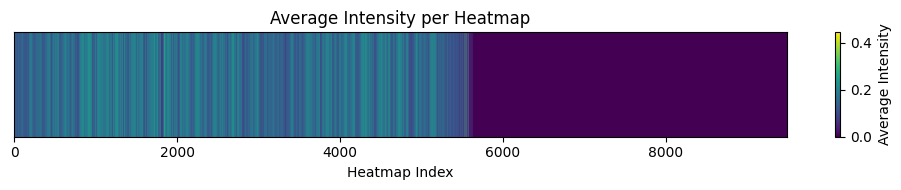

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_84']]
Received: inputs=Tensor(shape=(1, 500, 3))
  warnings.warn(msg)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# --- Step 1: Identify the last Conv1D layer in the model ---
def get_last_conv1d_layer(model):
    """
    Returns the name of the last Conv1D layer in the given model.

    Args:
        model: A compiled Keras model instance.

    Returns:
        Name of the last Conv1D layer or None if not found.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, keras.layers.Conv1D):
            return layer.name
    return None

# --- Step 2: Define the Grad-CAM function for 1D data ---
def apply_gradcam_to_predictions(model, X_data, target_layer_name):
    """
    Applies Grad-CAM to each sample in X_data using the specified Conv1D layer.

    Parameters:
        model (keras.Model): Trained Keras model.
        X_data (np.ndarray): Input samples (3D array: [samples, timesteps, features]).
        target_layer_name (str): Name of the Conv1D layer to compute Grad-CAM on.

    Returns:
        List of heatmaps (one per sample).
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(target_layer_name).output, model.output]
    )

    heatmaps = []

    for sample in X_data:
        sample = np.expand_dims(sample, axis=0)  # Add batch dimension

        with tf.GradientTape() as tape:
            conv_output, prediction = grad_model(sample)
            target_output = prediction[0]  # Single output for regression/classification

        # Compute gradients of the output with respect to the conv layer output
        grads = tape.gradient(target_output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Global average pooling

        # Weight the conv output channels by importance
        conv_output = conv_output[0]
        weighted_output = conv_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(weighted_output)

        # Normalize the heatmap
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-6)
        heatmaps.append(heatmap.numpy())

    return heatmaps

# --- Step 3: Visualize heatmaps for a few test samples ---
#def plot_heatmaps(heatmaps, num_samples=3, title_prefix="Sample"):
   # for i, heatmap in enumerate(heatmaps[:num_samples]):
   #     plt.figure()
     #  plt.plot(heatmap)
      #  plt.xlabel("Steps")
      #  plt.ylabel("Activation Intensity")
      #  plt.title(f"{title_prefix} {i + 1}")
       # plt.tight_layout()
      #  plt.show()

# --- Step 4: Compute and plot the average heatmap ---
#def plot_average_heatmap(heatmaps, title="Average Heatmap"):
  #  heatmap_array = np.array(heatmaps)
   # average_heatmap = np.mean(heatmap_array, axis=0)

   # plt.figure()
  #  plt.plot(average_heatmap)
  #  plt.xlabel("Steps")
  #  plt.ylabel("Average Activation Intensity")
   # plt.title(title)
  #  plt.tight_layout()
  #  plt.show()

# --- Step 5: Example usage on test data ---
model = ensemble_models[0]  # pick one model from the ensemble
target_layer_name = get_last_conv1d_layer(model)
test_heatmaps = apply_gradcam_to_predictions(model, X_test, target_layer_name)
# --- Optional: Compute average intensity per heatmap ---
average_intensities = [np.mean(hm) for hm in test_heatmaps]

# Convert average intensities to a 2D array (1 row, N columns)
average_intensities_array = np.array(average_intensities)[np.newaxis, :]
# Plot heatmap
plt.figure(figsize=(10, 2))
plt.imshow(average_intensities_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Average Intensity')
plt.xlabel("Heatmap Index")
plt.yticks([])  # Hide y-axis ticks (optional)
plt.title("Average Intensity per Heatmap")
plt.tight_layout()
plt.show()

# --- Step 6: Example usage on training data ---
train_heatmaps = apply_gradcam_to_predictions(model, X_train, target_layer_name)
average_intensities_train = [np.mean(hm) for hm in train_heatmaps]
average_intensities_array_train = np.array(average_intensities_train)[np.newaxis, :]
# Plot heatmap
plt.figure(figsize=(10, 2))
plt.imshow(average_intensities_array_train, cmap='viridis', aspect='auto')
plt.colorbar(label='Average Intensity')
plt.xlabel("Heatmap Index")
plt.yticks([])  # Hide y-axis ticks (optional)
plt.title("Average Intensity per Heatmap")
plt.tight_layout()
plt.show()